<a href="https://colab.research.google.com/github/julietlawton/image-captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning

## Setup

In [ ]:
# Install croissant
!pip install -q mlcroissant

from mlcroissant import Dataset

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
import random
import ast
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from PIL import Image
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Dataset

In [ ]:
# Define a global variable that determines how to load the dataset
USE_CROISSANT = False

# Get the device for this session
devices = tf.config.list_physical_devices('GPU')
device_name = tf.config.experimental.get_device_details(devices[0])['device_name']

# If this session uses the A100 GPU, load the data with croissant
if "A100" in device_name:
  USE_CROISSANT = True

print(USE_CROISSANT)

True


### Download from HuggingFace to disk

In [ ]:
if not USE_CROISSANT:
  # Download annotations (captions)
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv

  # Download and unzip images
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr30k-images.zip
  !unzip flickr30k-images.zip

In [ ]:
if not USE_CROISSANT:
  # Load annotations and image metadata into a dataframe
  flickr30k_df = pd.read_csv("flickr_annotations_30k.csv", converters={"raw": ast.literal_eval})
  flickr30k_df.rename(columns={"raw": "captions"}, inplace=True)
  display(flickr30k_df.head())
  print(flickr30k_df.info())

  # Verify that the images downloaded correctly
  img_file = flickr30k_df["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_file}")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### Download with Croissant

In [ ]:
if USE_CROISSANT:
  # Download Flickr30k metadata from hugging face with croissant
  flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
  records = flickr30k_ds.records("TEST")

  # Print the names of the available record sets
  record_sets = flickr30k_ds.metadata.record_sets
  print(record_sets)

  # Load the images and captions into a dataframe (uses RAM)
  flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
  display(flickr30k_df.head())
  flickr30k_df.info()

  -  [Metadata(flickr30k)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/version" is recommended, but does not exist.


[RecordSet(uuid="TEST")]


TEST/image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                        TEST/caption  \
0  [b'Two young guys with shaggy hair look at the...   
1  [b'Several men in hard hats are operating a gi...   
2  [b'A child in a pink dress is climbing up a se...   
3  [b'Someone in a blue shirt and hat is standing...   
4  [b'Two men, one in a gray shirt, one in a blac...   

                          TEST/sentids TEST/split TEST/img_id  \
0       [b'0', b'1', b'2', b'3', b'4']   b'train'        b'0'   
1       [b'5', b'6', b'7', b'8', b'9']   b'train'        b'1'   
2  [b'10', b'11', b'12', b'13', b'14']   b'train'        b'2'   
3  [b'15', b'16', b'17', b'18', b'19']   b'train'        b'3'   
4  [b'20', b'21', b'22', b'23', b'24']   b'train'        b'4'   

       TEST/filename  
0  b'1000092795.jpg'  
1    b'10002456.jpg'  
2  b'1000268201.jpg'  
3  b'1000344755.jpg'  
4  b'1000366164.jpg'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TEST/image     31014 non-null  object
 1   TEST/caption   31014 non-null  object
 2   TEST/sentids   31014 non-null  object
 3   TEST/split     31014 non-null  object
 4   TEST/img_id    31014 non-null  object
 5   TEST/filename  31014 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [ ]:
if USE_CROISSANT:
  # Rename the columns
  flickr30k_df.rename(columns={
      "TEST/image": "image",
      "TEST/caption": "captions",
      "TEST/sentids": "sentids",
      "TEST/split": "split",
      "TEST/img_id": "img_id",
      "TEST/filename": "filename"
      },
      inplace=True
  )

  # Convert byte strings to strings
  flickr30k_df["split"] = flickr30k_df["split"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["img_id"] = flickr30k_df["img_id"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["filename"] = flickr30k_df["filename"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["captions"] = flickr30k_df["captions"].apply(lambda captions: [caption.decode("utf-8") for caption in captions])
  flickr30k_df["sentids"] = flickr30k_df["sentids"].apply(lambda ids: [id.decode("utf-8") for id in ids])
  display(flickr30k_df.head())

image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                            captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split img_id        filename  
0  train      0  1000092795.jpg  
1  train      1    10002456.jpg  
2  train      2  1000268201.jpg  
3  train      3  1000344755.jpg  
4  train      4  1000366164.jpg

## Exploratory Data Analysis

In [ ]:
# Helper function to search images by caption
def search_image_by_caption(text, show_image=False, exact_match=False):

  # Search all captions by text input (case insensitive)
  if exact_match:
    # Returns any image with a caption that matches the full input
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower() for caption in x))]
  else:
    # Returns any image with a caption that contains the keyword
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower().split() for caption in x))]

  if not results.empty and show_image:
    # Display a random image if there is more than one match
    n = len(results)
    idx = 0 if n <= 1 else random.randint(0, n-1)
    filename = results["filename"].values[idx]

    # If using croissant, retrieve the image from the dataframe
    # else, load the image from disk
    if USE_CROISSANT:
      img = results["image"].values[idx]
    else:
      img = Image.open(f"flickr30k-images/{filename}")

    # Plot image
    plt.imshow(img)
    plt.axis('off')
    print(filename)
    plt.show()

  return results if not results.empty else "No matches."

4756001275.jpg


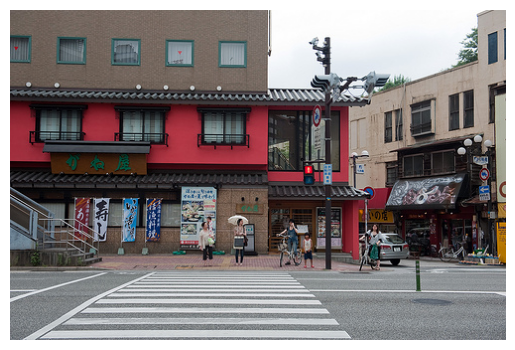

image  \
1322   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
7853   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
20566  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
22380  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
22965  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
23572  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
26529  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
28953  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
29619  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                captions  \
1322   [A tall, thin, brunette girl wearing combat bo...   
7853   [There is a person in zebra striped pants and ...   
20566  [Two young women walking, one tall, blond, mod...   
22380  [Some people standing at the corner of a stree...   
22965  [A young girl with blue and pink ribbons in he...   
23572  [An African-American young man is sitting on a...   
26529  [A person dressed up like a panda has surprise...   
28953  [A girl, about 8 years old, is sitting in fron...   
29619  [A girl wearing a black bikini jumps into a la...   

                                        sentids  split img_id        filename  
1322             [6610, 6611, 6612, 6613, 6614]  train   1322  1400424834.jpg  
7853        [39265, 39266, 39267, 39268, 39269]  train   7853   270684372.jpg  
20566  [102830, 102831, 102832, 102833, 102834]  train  20566  4603100449.jpg  
22380  [111900, 111901, 111902, 111903, 111904]  train  22380  4756001275.jpg  
22965  [114825, 114826, 114827, 114828, 114829]  train  22965  4805835848.jpg  
23572  [117860, 117861, 117862, 117863, 117864]  train  23572  4851225205.jpg  
26529  [132645, 132646, 132647, 132648, 132649]  train  26529  5582687203.jpg  
28953  [144765, 144766, 144767, 144768, 144769]  train  28953  7033675245.jpg  
29619  [148095, 148096, 148097, 148098, 148099]  train  29619   755396653.jpg

In [ ]:
# Test image search helper function (keyword search)
search_image_by_caption("zebra", show_image=True)

5450688421.jpg


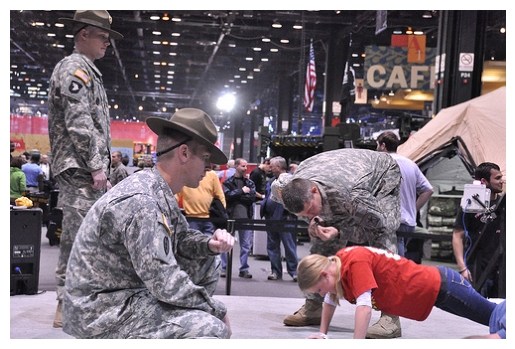

image  \
26308  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                captions  \
26308  [Two soldiers at an event center are watching ...   

                                        sentids  split img_id        filename  
26308  [131540, 131541, 131542, 131543, 131544]  train  26308  5450688421.jpg

In [ ]:
# Test image search helper function (exact match)
search_image_by_caption("Think you can do as many as the lieutenant?", show_image=True, exact_match=True)

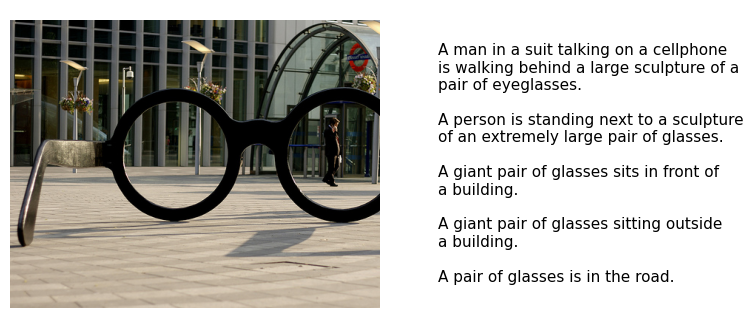

In [ ]:
# Pick a random image
rs = flickr30k_df.sample(n=1)

# Plot the image and its captions
fig, ax = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [5, 1]})

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Plot the image
ax[0].imshow(img)
ax[0].set_axis_off()

# Plot the captions
captions = rs["captions"].iloc[0]
ax[1].text(0.5, 0.5, "\n\n".join([textwrap.fill(caption, width=40) for caption in captions]), va='center', fontsize=11)
ax[1].set_axis_off()

plt.subplots_adjust(wspace=0.1)
plt.show()

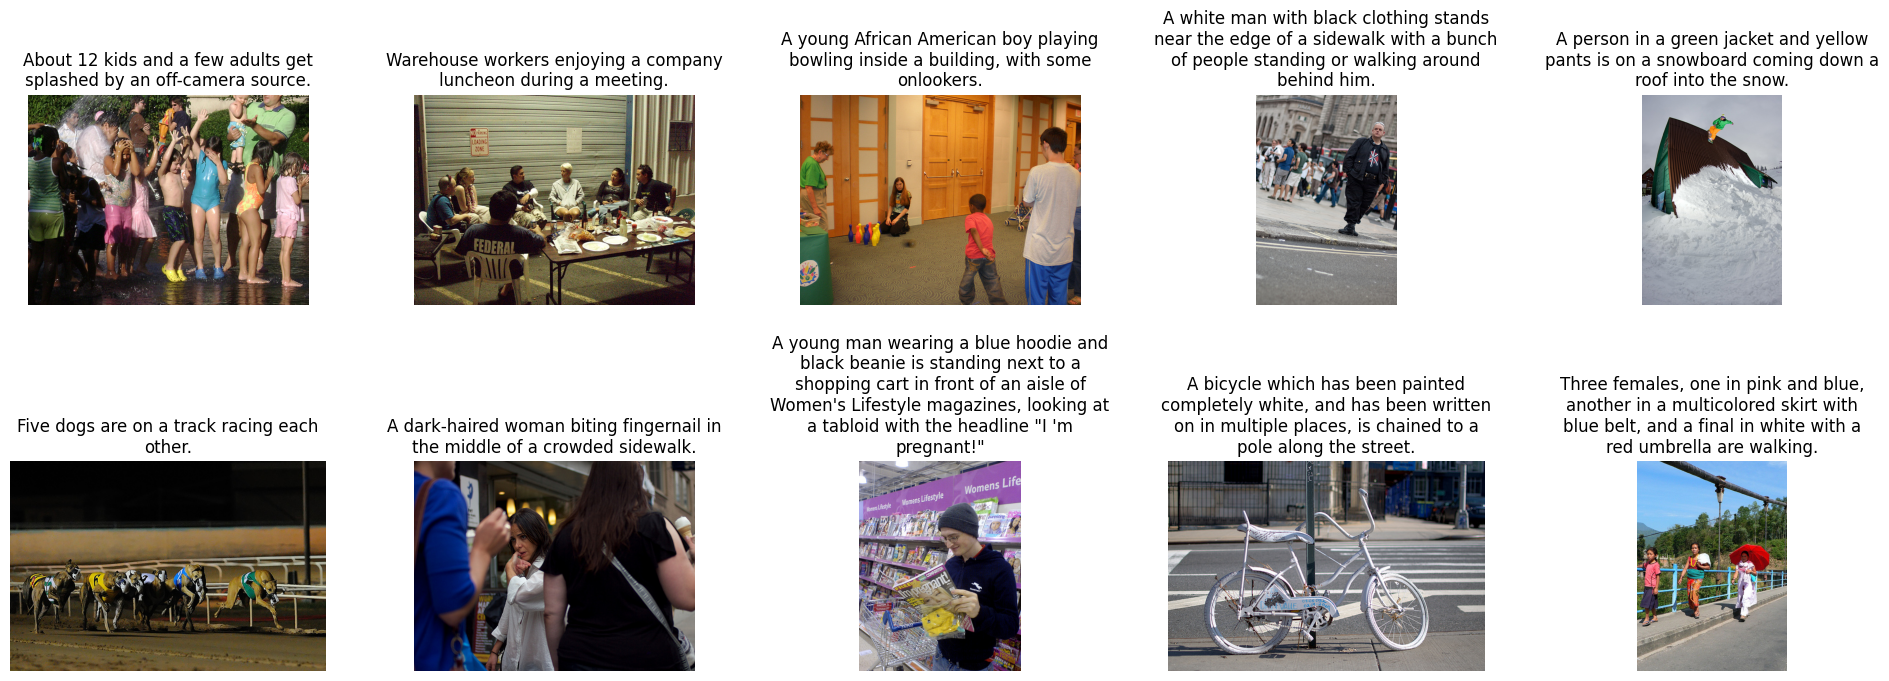

In [ ]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

# Plot each image and its first caption
for i, ax in enumerate(axs):
  if USE_CROISSANT:
    img = rs["image"].values[i]
  else:
    img_name = rs["filename"].values[i]
    img = Image.open(f"flickr30k-images/{img_name}")
  ax.imshow(img)
  caption = rs["captions"].iloc[i][0]
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

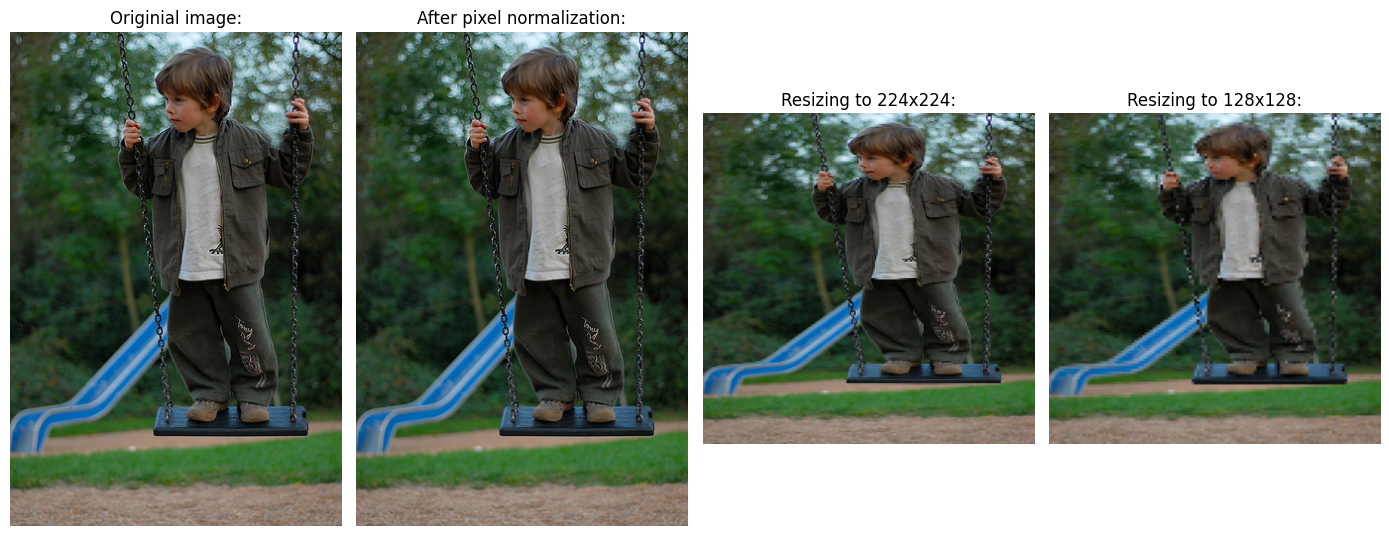

In [ ]:
# Test image preprocessing methods
rs = flickr30k_df.sample(n=1)

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Normalize the pixel values
img_tensor = tf.convert_to_tensor(img)
img_norm = img_tensor/255

# Resize the image to 224x224
img_224 = tf.image.resize(img_norm, [224, 224])

# Resize the image to 128x128
img_128 = tf.image.resize(img_norm, [128, 128])

# Plot the original image and each of its transformations
fig, ax = plt.subplots(1, 4, figsize=(14, 7))
ax[0].set_title("Originial image:")
ax[0].imshow(img)
ax[0].axis('off')
ax[1].set_title("After pixel normalization:")
ax[1].imshow(img_norm)
ax[1].axis('off')
ax[2].set_title("Resizing to 224x224:")
ax[2].imshow(img_224)
ax[2].axis('off')
ax[3].set_title("Resizing to 128x128:")
ax[3].imshow(img_128)
ax[3].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
# Get all of the captions for EDA
all_captions = [caption for captions in flickr30k_df["captions"] for caption in captions]
all_captions[:5]

['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
 'Two young, White males are outside near many bushes.',
 'Two men in green shirts are standing in a yard.',
 'A man in a blue shirt standing in a garden.',
 'Two friends enjoy time spent together.']

Total number of captions: 155070
Mean caption length: 63.2
Median caption length: 58.0
Caption length standard dev: 26.68
Min length: 7
Q1: 45.0
Q3: 75.0
95th percentile: 113.0
Max length: 402


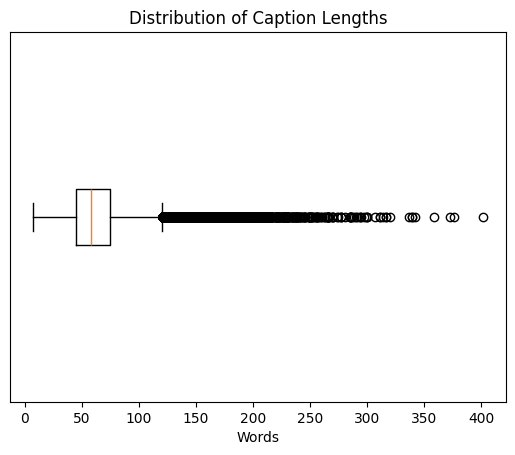

In [ ]:
# Compute descriptive statistics for the captions
print(f"Total number of captions: {len(all_captions)}")

caption_lengths = [len(caption) for caption in all_captions]

print(f"Mean caption length: {np.round(np.mean(caption_lengths), 2)}")
print(f"Median caption length: {np.median(caption_lengths)}")
print(f"Caption length standard dev: {np.round(np.std(caption_lengths), 2)}")
print(f"Min length: {np.min(caption_lengths)}")
print(f"Q1: {np.quantile(caption_lengths, 0.25)}")
print(f"Q3: {np.quantile(caption_lengths, 0.75)}")
print(f"95th percentile: {np.quantile(caption_lengths, 0.95)}")
print(f"Max length: {np.max(caption_lengths)}")

# Plot the distribution
plt.title("Distribution of Caption Lengths")
plt.xlabel("Words")
plt.boxplot(caption_lengths, vert=0)
plt.yticks([])
plt.show()

In [ ]:
# Find non-alphabetic characters in the captions
unique_chars = {char for caption in all_captions for char in caption if not char.isalpha()}
print(unique_chars)

{'!', '-', ':', "'", ' ', '(', '1', '?', '5', '6', '4', '+', '3', ';', '8', '7', '0', ',', '@', '#', '=', '2', '&', '9', '`', '$', ')', '%', '"', '.'}


In [ ]:
# Inspect instances of captions that use non-alphabetic characters (pound sign)
special_char_captions = [caption for caption in all_captions if "#" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 41


['A UH football player, #15, stands near the edge of the field ready to throw the ball while his teammate blocks an opponent.',
 'A little-league baseball player, wearing a white #19 jersey, successfully hits the ball.',
 'A football player is in a red and white uniform Sooners #28.',
 'A black greyhound, with a green and white jersey (#7) is running on a track.',
 'The #2 greyhound dog is running around a track.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (at sign)
special_char_captions = [caption for caption in all_captions if "@" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['@ men are kneeling with their hands in front of them.',
 '@ people are cleaning windows in a dark environment.',
 '@ males wearing a black shirt and a brown shirt are looking at vegetation.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (percent sign)
special_char_captions = [caption for caption in all_captions if "%" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 12


['Man outside in the rain promoting a 50 % off sale.',
 'An elderly man held the "COLLEGE KRUGT DINERS EN 3 %" sign as he stood near the brick building.',
 'A group of women are all sitting in a department store looking at some papers or booklets, and a large sign indicates 40 % off sale.',
 '2 men getting ready to cross the street under the 25 % off sign.',
 '2 rows of woman walking towards each other on the sidewalk outside of a store with a boy 50 % sign on the golden framed windows.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (colon)
special_char_captions = [caption for caption in all_captions if ":" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[10:15]

Total instances: 31


['Left to right : a girl in an orange coat, a young boy with a camera and red coat, and a woman with a scarf.',
 "Celebrating St. Patrick's Day at 2:10 pm &amp; an police officer is going inside a room.",
 'A group of men finish a fund raising run for Haiti in 28:24.',
 'A large gold trimmed clock indicates that the time is 1:10.',
 'A woman in a blue coat walks in front of a sign with green men walking under the two words :berlin and kathmandu']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (equal sign)
special_char_captions = [caption for caption in all_captions if "=" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 2


['Two young children RIF=ding sleds down the snow.',
 'People passing through an open market, while an older woman leans in front of a chilled bin on=f seafood.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (plus sign)
special_char_captions = [caption for caption in all_captions if "+" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['A Chinese + man and younger boy in some type of worship place worshiping.',
 'An elderly woman wearing a green parka +is walking with a cane near an intersection.',
 '8+ people sitting on wood benches are viewing 8 people in brown.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (ampersand)
special_char_captions = [caption for caption in all_captions if "&" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 90


['Grocery store employee, dressed in a red apron &amp; a baseball cap, sits on a ledge in front of the store.',
 'Two ladies are cooking &amp; talking and two gentlemen are talking in the opposite site of the kitchen.',
 'A woman in a black shirt sitting behind a booth with a sign that reads "Programmes &amp; Ice Cream."',
 'Eight gentlemen are working with stone &amp; tile.',
 'A dozen workers wearing uniforms &amp; sanitation hats are working on an assembly line in a factory.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (question mark)
special_char_captions = [caption for caption in all_captions if "?" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions

Total instances: 38


['A crowd admiring modern art?',
 'The green team lifts a player up in victory after a hard game, but will the red team interfere?',
 'It takes a real man to clean a bucket with who knows what in it?',
 "That hotdog just wasn't going down right, was it the drinking or the burnt dog?",
 'People walking through a short tunnel with "Where are you?" written on the wall.',
 'A man walks under a bridge and reads grafitti that reads "WHERE ARE YOU"?',
 'A man with a cigerette walks past graffitti which says "Where are you?"',
 'A man is walking next to a wall with "Where are you?" painted on it.',
 'A man walking reads a wall asking "Where are you?".',
 'How do we get to the other side?',
 'A person riding transit (catching?) a paper bag.',
 'Two people pose for a picure holding a card that says "know what this is?"',
 'Two girls hold up a card reading "know what this is"?',
 'Man with cupcakes and coffee contemplating the statement "who are you?"',
 'A man in glasses writes the message "Who 

460921330.jpg


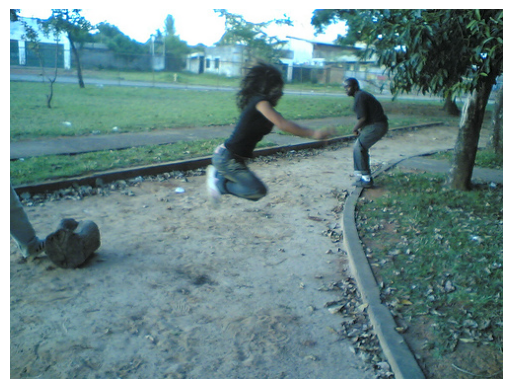

['A girl in a black shirt is jumping in a sandy area, and a man in a black shirt is bending over in the background.',
 "Did someone yell snake? Because it seems she's out of here!",
 'A woman jumping as a man idly watches her in midair.',
 'She is jumping high in the air.',
 'People outdoors at a park.']

In [ ]:
results = search_image_by_caption("Did someone yell snake? Because it seems she's out of here!", show_image=True, exact_match=True)
results["captions"].iloc[0]

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (exclamation mark)
special_char_captions = [caption for caption in all_captions if "!" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 96


['Looks like everyone is getting good gas mileage here with all these beautiful scooters!',
 'Man on an ATV catching air!',
 'Roller derby girls waiting for the next round of action!',
 'A sweet young lady deciding whats for breakfast!',
 'A yellow taxi cab with a sign reading "MAMA MIA!" on it, and a guy sitting in the back.']

In [ ]:
# Inspect instances of captions that use non-alphabetic characters (numbers)
special_char_captions = [caption for caption in all_captions if any(char in caption for char in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 1776


['2 kids playing on a seesaw',
 'Small group of 5 white males in white suits hanging out by the back of a van in a parking lot talking.',
 '2 female babies eating chips.',
 'Man walking up to silver 4-wheeled chair',
 'A man in an orange shirt sings for the crowd below a sign that says Lucky 13.']

## Caption Preprocessing

### Text Cleaning

In [ ]:
# Save all the captions before cleaning to compare difference in vocabulary size
all_captions_raw = [caption for captions in flickr30k_df["captions"] for caption in captions]

In [ ]:
def preprocess_captions(captions):
  cleaned_captions = []
  for caption in captions:
    # Convert caption to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = re.sub(r"[.,;!?`]", "", caption)

    # Replace pound sign with the word number
    caption = caption.replace("#", "number")

    # Replace percent sign with the word percent
    caption = caption.replace("%", "percent")

    # Replace ampersand with the word and
    caption = caption.replace("&amp", "and")

    # Remove other characters that are not useful
    caption = re.sub(r"[@+=()]", "", caption)

    # Remove excess whitespace
    caption = re.sub(r"\s+", " ", caption).strip()

    cleaned_captions.append(caption)

  return cleaned_captions

In [ ]:
# Test the text preprocessing method on a single text
test_caption = ["Test.  caption (12), &amp; 34 @; + # % !", "(anoth=r) test caption"]
print(f"Original captions: {test_caption}")
print(f"After cleaning: {preprocess_captions(test_caption)}")

Original captions: ['Test.  caption (12), &amp; 34 @; + # % !', '(anoth=r) test caption']
After cleaning: ['test caption 12 and 34 number percent', 'anothr test caption']


In [ ]:
# Apply preprocessing method to all the captions
flickr30k_df["captions"] = flickr30k_df["captions"].apply(preprocess_captions)
flickr30k_df["captions"].head()

0    [two young guys with shaggy hair look at their...
1    [several men in hard hats are operating a gian...
2    [a child in a pink dress is climbing up a set ...
3    [someone in a blue shirt and hat is standing o...
4    [two men one in a gray shirt one in a black sh...
Name: captions, dtype: object

### Caption Tokenization and Encoding

In [ ]:
# Define a method to create a token vocabulary from the caption text corpus
def create_vocabulary(captions):

  # Create a set to store unique tokens
  unique_tokens = set()

  # Add the start and end sequence tokens to the vocabulary
  special_tokens = ["<START>", "<END>"]
  unique_tokens.update(special_tokens)

  # Tokenize each caption and add its tokens to the vocabulary
  for caption in captions:
    caption_tokens = word_tokenize(caption)
    unique_tokens.update(caption_tokens)
  return unique_tokens

# Get all of the captions
all_captions_cleaned = [caption for captions in flickr30k_df["captions"] for caption in captions]

# Test on the first caption
single_caption_vocab = create_vocabulary(all_captions_cleaned[:1])
print(all_captions_cleaned[:1])
print(single_caption_vocab)

['two young guys with shaggy hair look at their hands while hanging out in the yard']
{'look', '<END>', 'their', 'young', '<START>', 'with', 'the', 'yard', 'shaggy', 'while', 'two', 'hands', 'guys', 'at', 'hanging', 'out', 'in', 'hair'}


In [ ]:
# Create the full vocabulary (raw captions)
full_vocab = create_vocabulary(all_captions_raw)

# Print vocab size (raw captions size)
print(f"Vocab size (without text cleaning): {len(full_vocab)}")

Vocab size (without text cleaning): 23314


In [ ]:
# Create the full vocabulary (cleaned captions)
full_vocab = create_vocabulary(all_captions_cleaned)

# Print vocab size (cleaned captions)
print(f"Vocab size (after text cleaning): {len(full_vocab)}")

Vocab size (after text cleaning): 20153


In [ ]:
# Caption encoder base class
# Must specify a method of encoding a caption and decoding a caption
class CaptionEncoder:
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length
  # Encoding method
  def encode(self, caption):
    pass
  # Decoding method
  def decode(self, encoding):
    pass

In [ ]:
# Define a class that creates a custom caption encoder object that handles tokenizing and
# encoding/decoding a set of captions
class CustomCaptionEncoder(CaptionEncoder):
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # Define mappings for token to id and id to token
    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    # Add the start sequence token to the beginning on the caption tokens
    caption_tokens = ["<START>"] + word_tokenize(caption)

    # Convert each token to its id
    encoding = [self.token_to_id[token] for token in caption_tokens]

    # If the sequence is too short, pad it to the sequence length
    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    # If the sequence is too long, truncate it to the sequence length
    else:
      encoding = encoding[:self.seq_length-1]

    # Add the end sequence token
    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    # Convert the encoding back into tokens
    return [self.id_to_token[id] for id in encoding if id != 0]


In [ ]:
# Test the custom caption encoder on the vocabulary from a single caption
encoder = CustomCaptionEncoder(single_caption_vocab, 25)
print(f"Token to ID mapping: {encoder.token_to_id}")
print(f"ID to Token mapping: {encoder.id_to_token}\n")

# Encode the first caption
encoded_caption = encoder.encode(all_captions_cleaned[0])
print(f"Encoded caption: {encoded_caption}")

# Decode the encoded caption
print(f"Decoded caption: {encoder.decode(encoded_caption)}")

Token to ID mapping: {'look': 1, '<END>': 2, 'their': 3, 'young': 4, '<START>': 5, 'with': 6, 'the': 7, 'yard': 8, 'shaggy': 9, 'while': 10, 'two': 11, 'hands': 12, 'guys': 13, 'at': 14, 'hanging': 15, 'out': 16, 'in': 17, 'hair': 18}
ID to Token mapping: {1: 'look', 2: '<END>', 3: 'their', 4: 'young', 5: '<START>', 6: 'with', 7: 'the', 8: 'yard', 9: 'shaggy', 10: 'while', 11: 'two', 12: 'hands', 13: 'guys', 14: 'at', 15: 'hanging', 16: 'out', 17: 'in', 18: 'hair'}

Encoded caption: [5, 11, 4, 13, 6, 9, 18, 1, 14, 3, 12, 10, 15, 16, 17, 7, 8, 0, 0, 0, 0, 0, 0, 0, 2]
Decoded caption: ['<START>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<END>']


In [ ]:
# Create a custom caption encoder on the full vocabulary to use in the models
custom_caption_encoder = CustomCaptionEncoder(full_vocab, 120)

## Data Generator

In [ ]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["split"] == 'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["split"] == 'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["split"] == 'val']
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29000 entries, 0 to 31013
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     29000 non-null  object
 1   captions  29000 non-null  object
 2   sentids   29000 non-null  object
 3   split     29000 non-null  object
 4   img_id    29000 non-null  object
 5   filename  29000 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25 to 30943
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     1000 non-null   object
 1   captions  1000 non-null   object
 2   sentids   1000 non-null   object
 3   split     1000 non-null   object
 4   img_id    1000 non-null   object
 5   filename  1000 non-null   object
dtypes: object(6)
memory usage: 54.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 67 to 30999
Data columns (total 6 co

In [ ]:
# Define a class that builds a data generator object for dynamically loading data
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, caption_encoder, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.caption_encoder = caption_encoder
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]

    images = batch["image"]
    batch_captions = batch["captions"]
    caption_sequences = []
    y = []
    image_tensors = []

      # For each image, normalize its pixel values and resize it
    for img in images:
      img_tensor = tf.convert_to_tensor(img)
      img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
      img_tensor = img_tensor/255.0
      image_tensors.append(img_tensor)

    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      encoding = self.caption_encoder.encode(caption)

      for i in range(1, len(encoding)):
          # Create input and output sequences from the captions, e.g.
          # <START> -> a
          # <START> a -> sample
          # <START> a sample -> caption
        caption_input, output = encoding[:i], encoding[i]
        padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
        caption_input.extend(padding)
        output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
        caption_sequences.append(caption_input)
        y.append(output)
        # image_tensors.append(img_tensor)

        #image_captions.append(encoding)
    y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # # Load the images from the dataframe
    # if USE_CROISSANT:
    #   images = batch["image"]
    #   image_tensors = []

    #   # For each image, normalize its pixel values and resize it
    #   for img in images:
    #     img_tensor = tf.convert_to_tensor(img)
    #     img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
    #     img_tensor = img_tensor/255.0
    #     image_tensors.append(img_tensor)

    # # If the images are on disk, use multithreading to load and transform the images in parallel
    # else:
    #   image_files = batch["filename"]
    #   with ThreadPoolExecutor() as executor:
    #     image_tensors = list(executor.map(self.load_image_from_file, image_files))

    # # For each image, choose one of its captions at random and tokenize and encode it
    # image_captions = []
    # batch_captions = batch["captions"]

    # caption_sequences = []
    # y = []
    # for captions in batch_captions:
    #   caption_idx = random.randint(0, 4)
    #   caption = captions[caption_idx]
    #   encoding = self.caption_encoder.encode(caption)

    #   for i in range(1, len(encoding)):
    #     # Create input and output sequences from the captions, e.g.
    #     # <START> -> a
    #     # <START> a -> sample
    #     # <START> a sample -> caption
    #     caption_input, output = encoding[:i], encoding[i]
    #     padding = [0] * (self.caption_encoder.seq_length - 1 - len(caption_input))
    #     caption_input.extend(padding)
    #     #caption_input, output = caption[:i], caption[i]
    #     output = to_categorical([output], num_classes=self.caption_encoder.vocab_size)
    #     # print("in", caption_input)
    #     # print("out", output.shape)
    #     caption_sequences.append(caption_input)
    #     y.append(output)

    #   #image_captions.append(encoding)
    # y = np.array(y).reshape(-1, self.caption_encoder.vocab_size)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), y

    # # Return a batch of images and captions
    # return np.array(image_tensors) #, np.array(image_captions)

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

  # Helper function to load and preprocess an image from disk
  def load_image_from_file(self, filename):
    img = Image.open(f"flickr30k-images/{filename}")
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.image.resize(img_tensor, [128, 128])
    img_tensor = img_tensor/255.0
    return img_tensor

In [ ]:
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=32)

In [ ]:
len(generator)

907

In [ ]:
inputs, outputs = generator[0]

In [ ]:
inputs[0].shape

(32, 128, 128, 3)

In [ ]:
inputs[1].shape

(3808, 119)

In [ ]:
outputs.shape

(3808, 20153)

In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape

(401, 20153)

In [ ]:
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=64)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
img_batch, input_sequences_batch, output_sequences_batch = generator[0]

Batches per epoch: 454


In [ ]:
img_batch.shape, input_sequences.shape, output_sequences.shape

((64, 128, 128, 3), (401, 401), (401, 1, 20153))

In [ ]:
batch[1].shape

(401, 401)

In [ ]:
batch[2].shape

(401, 1, 20153)

In [ ]:
# Instantiate a data generator for testing
generator = DataGenerator(train_df, custom_caption_encoder, 128, 128, batch_size=64)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
img_batch, input_sequences_batch, output_sequences_batch = generator[0]
print(f"Images shape: {img_batch.shape}")
print(f"Caption input shape: {input_sequences_batch.shape}")
print(f"Ground truth shape: {output_sequences_batch.shape}")

# # Print an image from the batch and its caption
# print(" ".join(custom_caption_encoder.decode(caption_batch[0])))
# plt.imshow(img_batch[0])
# plt.show()

Batches per epoch: 454
Images shape: (64, 128, 128, 3)
Caption input shape: (401, 401)
Ground truth shape: (401, 1, 20153)


In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
num_epochs = 10

# Start experiment timer
test_start_time = time.time()

# For each epoch, retrieve every batch for that epoch
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")

  # Start epoch timer
  epoch_start_time = time.time()

  # Load each batch in the epoch
  for batch_idx in range(len(generator)):
    batch = generator[batch_idx]

  # Shuffle the data
  generator.on_epoch_end()

  # End epoch timer
  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

# End experiment timer
test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

## Models


### CNN + TBD

In [ ]:
mini_df = train_df.sample(n=1000)
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 23272 to 12299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     1000 non-null   object
 1   captions  1000 non-null   object
 2   sentids   1000 non-null   object
 3   split     1000 non-null   object
 4   img_id    1000 non-null   object
 5   filename  1000 non-null   object
dtypes: object(6)
memory usage: 54.7+ KB


In [ ]:
mini_generator = DataGenerator(mini_df, custom_caption_encoder, 128, 128, batch_size=8)

In [ ]:
image_input_shape = mini_generator[0][0][0].shape[1:]
caption_input_shape = mini_generator[0][0][1].shape[1:]
vocab_size = len(full_vocab)

In [ ]:
mini_generator[0][0][0].shape

(1592, 128, 128, 3)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Embedding, Concatenate, Add, add, Reshape, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
# Instantiate generators for each data split
im_width = 128
im_height = 128
batch_size = 32

train_generator = DataGenerator(train_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
test_generator = DataGenerator(test_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)
val_generator = DataGenerator(val_df, custom_caption_encoder, im_width, im_height, batch_size=batch_size)

In [ ]:
train_generator[0][0][0].shape

(32, 128, 128, 3)

In [ ]:
image_input_shape = train_generator[0][0][0].shape[1:]
caption_input_shape = train_generator[0][0][1].shape[1:]
vocab_size = len(full_vocab)

In [ ]:
train_generator[0][0][1].shape[0]

3808

In [ ]:
image_input_shape, caption_input_shape

((128, 128, 3), (119,))

In [ ]:
train_generator.caption_encoder.seq_length

120

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(16, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
d1 = Dense(units=12)(p1)

repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(d1)
#im = Reshape((1, 12))(d1)

caption_input = Input(shape=caption_input_shape)

e = Embedding(vocab_size, 12, mask_zero=False)(caption_input)

concat = Concatenate(axis=1)([im, e])

lstm = LSTM(256)(concat)
output = Dense(units=vocab_size, activation="softmax")(lstm)

model = Model([image_input, caption_input], output)

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(16, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
d1 = Dense(units=128)(p1)

repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(d1)

caption_input = Input(shape=caption_input_shape)
e = Embedding(vocab_size, 128, mask_zero=False)(caption_input)
lstm1 = LSTM(128, return_sequences=True)(e)


add = Add()([repeat, lstm1])
#concat = Concatenate(axis=-1)([repeat, lstm1])
lstm2 = LSTM(128)(concat)
d2 = Dense(256, activation="relu")(lstm2)


output = Dense(units=vocab_size, activation="softmax")(d2)

model = Model([image_input, caption_input], output)

In [ ]:
repeat.shape

(None, 119, 128)

In [ ]:
lstm1.shape

(None, 119, 128)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 126, 126, 32)   │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 124, 124, 16)   │          4,624 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 16)             │              0 │ conv2d_7[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 119)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │          2,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 119, 128)       │      2,579,584 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 119, 128)       │              0 │ dense_7[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 119, 128)       │        131,584 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 119, 256)       │              0 │ repeat_vector_3[0][0], │
│ (Concatenate)             │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 128)            │        197,120 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │         33,024 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 20153)          │      5,179,321 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,128,329 (31.01 MB)

 Trainable params: 8,128,329 (31.01 MB)

 Non-trainable params: 0 (0.00 B)

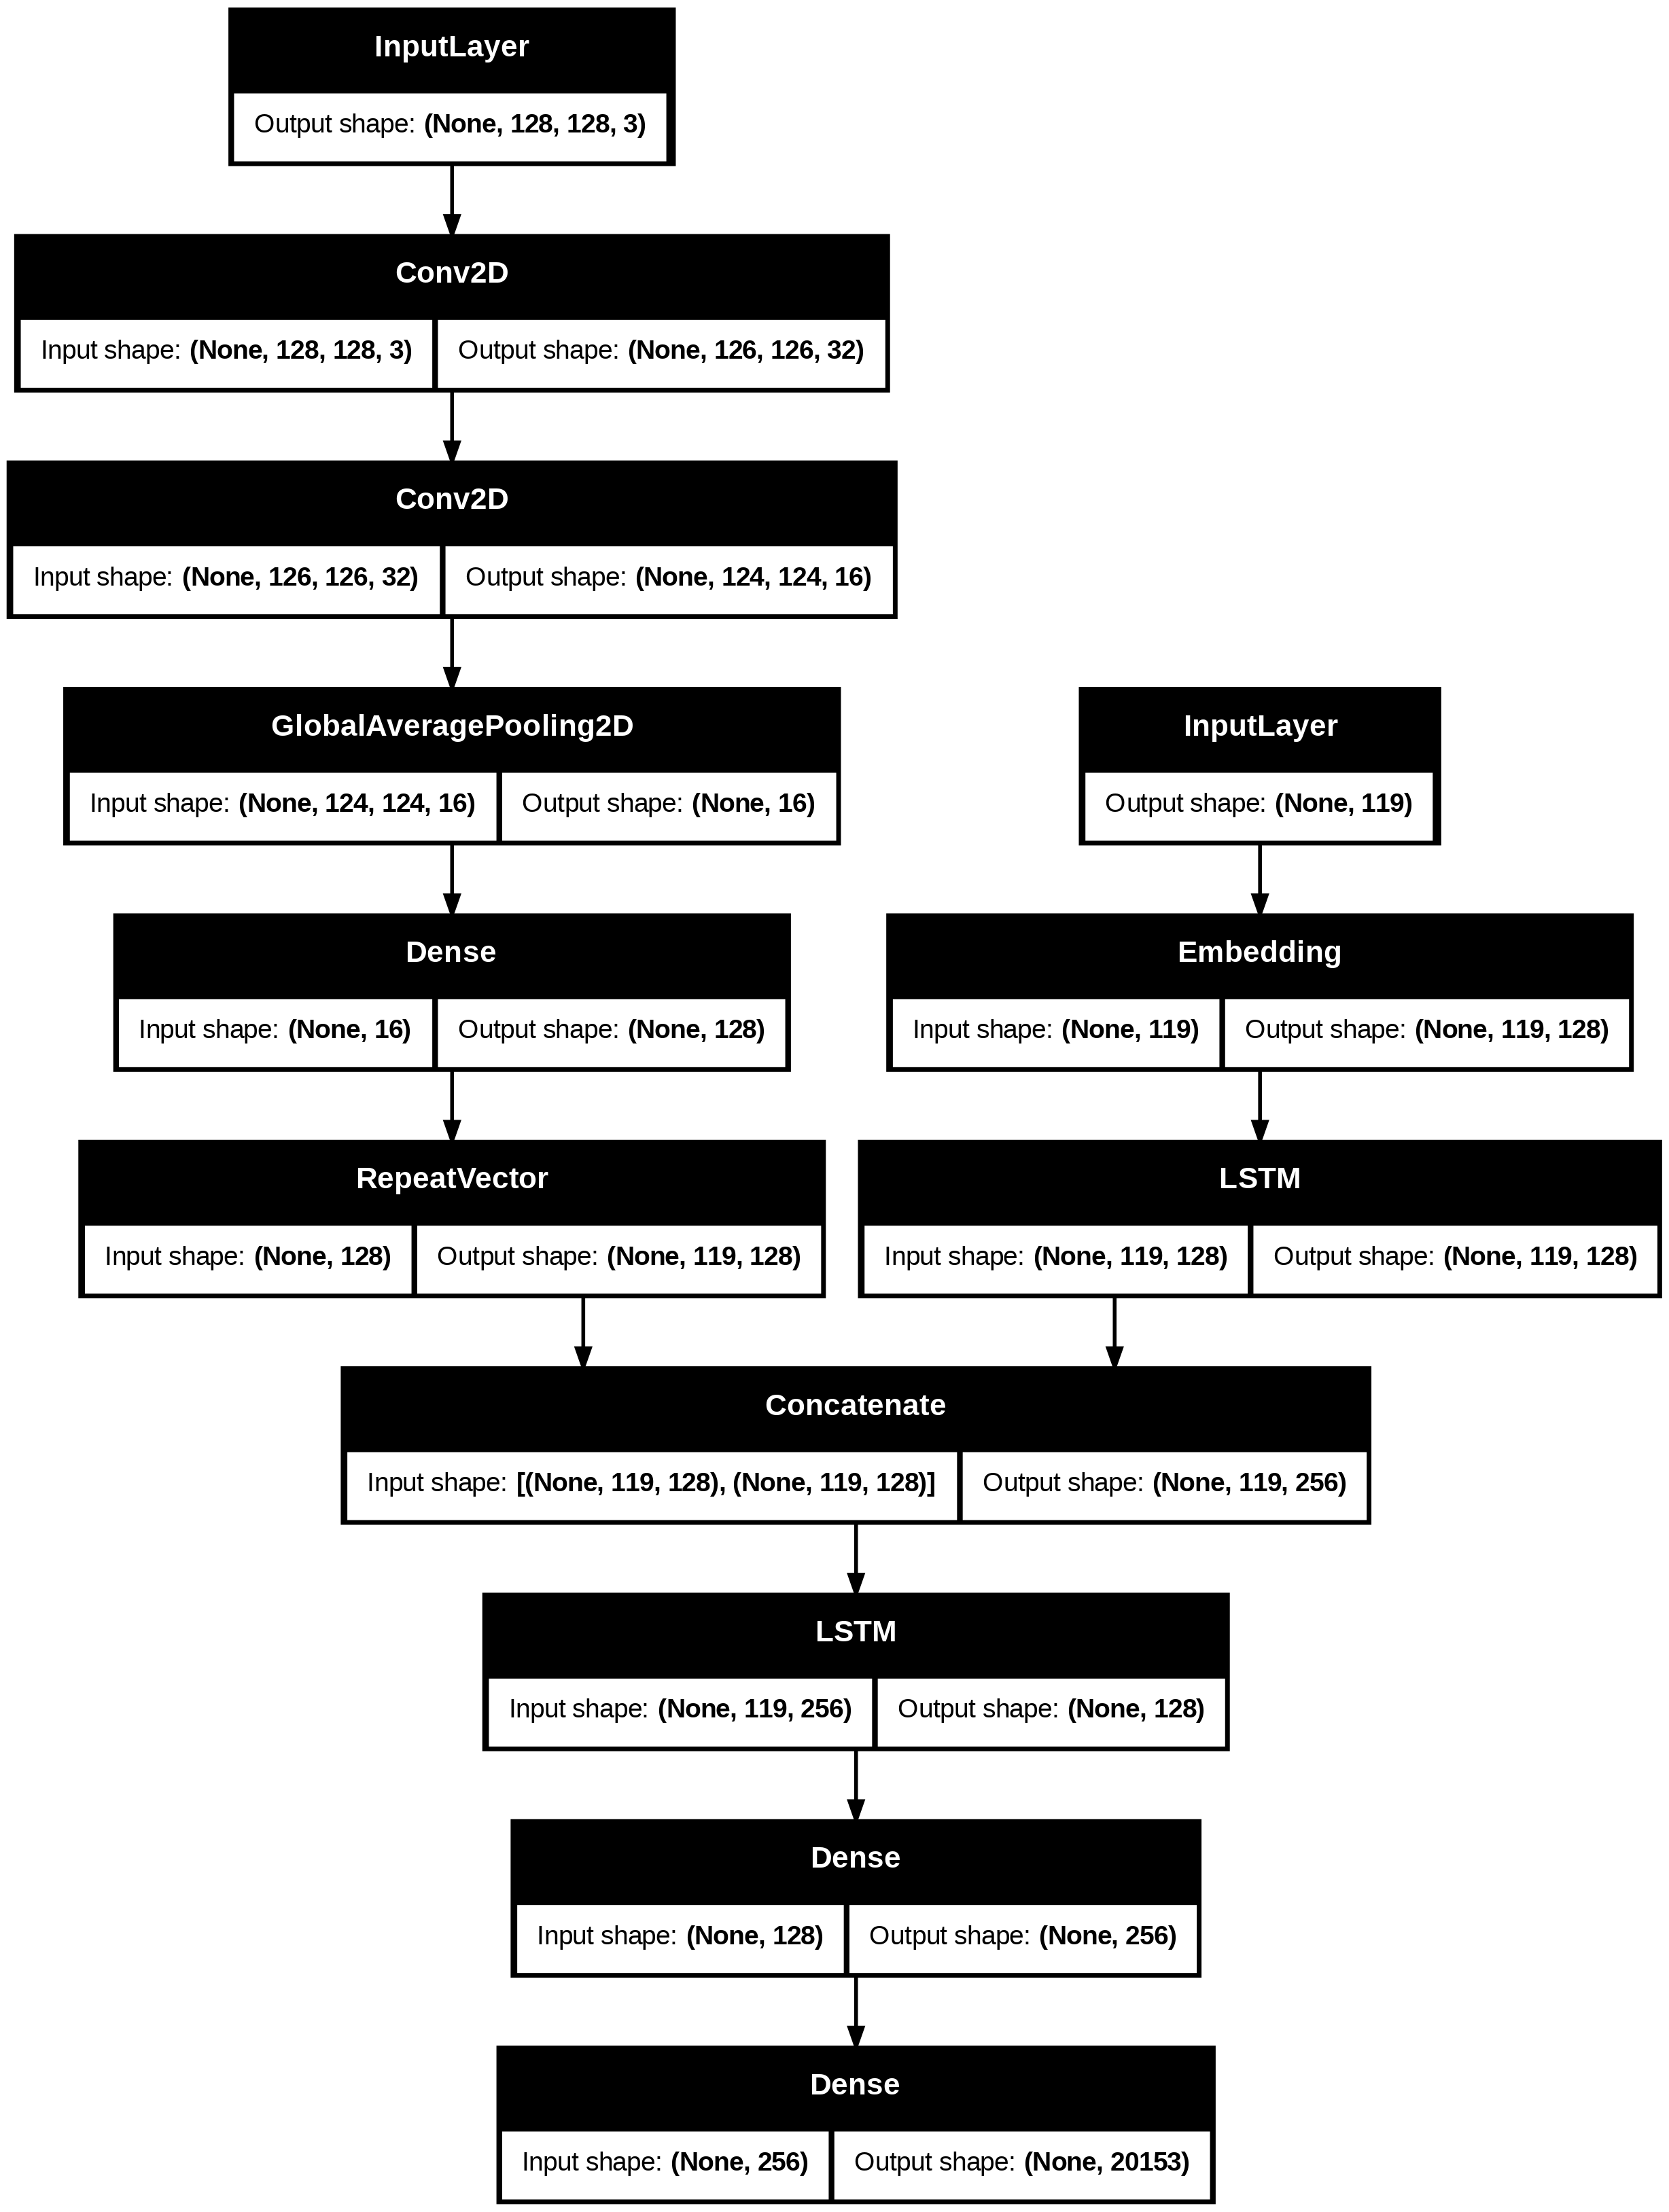

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
#Conv2D(32, 3, activation="relu")(train_generator[0][0])

In [ ]:
#Embedding(vocab_size, 12, mask_zero=True)(train_generator[0][1])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(train_generator, epochs=5)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node functional_2_1/concatenate_1_1/concat defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-80-6bc7cbb50a1c>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/merging/base_merge.py", line 226, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/merging/concatenate.py", line 101, in _merge_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 1352, in concatenate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 880, in concatenate

ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [32,119,128] vs. shape[1] = [3808,119,128]
	 [[{{node functional_2_1/concatenate_1_1/concat}}]] [Op:__inference_one_step_on_iterator_13025]

### CNN + GPT2

In [ ]:
# !pip install -q --upgrade keras-hub
# !pip install -q --upgrade keras


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D, Attention
from tensorflow.keras.models import Model
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer


In [ ]:
# Load GPT-2 model and tokenizer
gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
caption = caption_batch[0]
decode_batch_caption = caption_encoder.decode(caption_batch[0])
print(decode_batch_caption)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_encoded_caption = tokenizer.encode(decode_batch_caption, max_length=120, padding='max_length', truncation=True)
print(gpt_encoded_caption)
print(len(gpt_encoded_caption))

['<START>', 'Two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'a', 'yard', '.', '<END>']
[50256, 7571, 3653, 259, 14809, 23231, 533, 5646, 259, 64, 9413, 13, 50256, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]
120


In [ ]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, vocab_size, max_caption_shape=(80,), cnn_input_shape=(224, 224, 3)):
        super(ImageCaptioningModel, self).__init__()

        # Define the CNN for image feature extraction
        self.image_input = Input(shape=cnn_input_shape, name="image_input")
        self.caption_input = Input(shape=max_caption_shape, dtype=tf.int32, name="caption_input")

        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_cnn = Dense(256, activation="relu")
        self.dropout_cnn = Dropout(0.5)

        # Add a dense layer to project GPT-2 outputs to match the CNN feature dimension
        self.caption_projection = Dense(256, activation="relu")

        # Define dense layers for combining CNN and GPT-2 features
        self.concat = Concatenate(axis=1)
        self.dense_combined = Dense(256, activation="relu")
        self.dropout_combined = Dropout(0.5)
        self.output_layer = Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        # Split inputs into image and caption parts
        image, caption = inputs

        print("**cnn image processing**")
        # CNN forward pass
        x = self.conv2(image)
        print(x)
        x = self.pool2(x)
        print(x)
        x = self.conv2(x)
        print(x)
        x = self.pool2(x)
        print(x)
        image_features = self.dense_cnn(x)
        print('image features after dense', image_features.shape)
        image_features = self.dropout_cnn(image_features)
        print('image features after dropout_cnn', image_features.shape)


        # Project image features to match GPT-2 embedding size
        image_features = self.image_projection(image_features)

        # Tokenize prompt
        print('caption original shape', caption.shape)
        # tokenize here?
        input_ids = tokenizer(caption, return_tensors="pt").input_ids

        gen_tokens = self.gpt2_model.generate(
            input_ids,
            do_sample=True,
            temperature=0.9,
            max_length=120,
        )
        gen_caption = tokenizer.batch_decode(gen_tokens)[0]
        print("gen text: ", gen_caption)

        print("logits", gen_tokens.logits)

        # Pass caption through GPT-2 model
        # gpt2_outputs = self.gpt2_model(caption)
        # print(type(gpt2_outputs))
        # caption_logits = gpt2_outputs.logits
        print("caption logit shape", gen_tokens.shape)

        caption_features = Dense(256, activation="relu")(caption_logits)
        caption_features = tf.reduce_mean(caption_features, axis=1)  # (64, 256)
        print("after caption features Dense 256 and reduce mean - img shape: ", image_features.shape, "caption shape", caption_features.shape)

        combined_features = self.concat([image_features, caption_features])  # (64, 512)
        print("originally combined features", combined_features.shape)
        # Process combined features with a dense layer
        combined_features = self.dense_combined(combined_features)
        combined_features = self.dropout_combined(combined_features)
        print("after dense and dropout combined features", combined_features.shape)
        # Output prediction for each word in the sequence
        output = self.output_layer(combined_features)
        return output

In [ ]:
# Set vocabulary size and other hyperparameters
vocab_size = tokenizer.vocab_size
max_caption_length = 120

# Instantiate and compile the model
model = ImageCaptioningModel(vocab_size=vocab_size, max_caption_length=max_caption_length)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
# 4. Invoke the model
input_data = (img_batch, caption_batch)
print("img shape:", input_data[0].shape, "caption shape", input_data[1].shape)

predictions = model(input_data)
print(predictions.shape)
print(predictions[0])

# Decode the full sequence of indices to get the generated caption for each image
predicted_captions = []
for sequence in predictions:
    # Decode the full sequence of word indices into a single caption string
    caption = tokenizer.decode(sequence, skip_special_tokens=True)  # Skip special tokens like padding
    predicted_captions.append(caption)

img shape: (64, 224, 224, 3) caption shape (64, 120)
image features after cnn (64, 256)
caption original shape (64, 120)
<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
image features after cnn (64, 256)
caption original shape (64, 120)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'image_captioning_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
(64, 50257)
tf.Tensor(
[1.3851303e-06 4.9406035e-06 1.9392479e-05 ... 3.3863493e-05 1.1885997e-05
 6.5515314e-06], shape=(50257,), dtype=float32)


In [ ]:
print(predictions[1])
print(predicted_captions[1])

tf.Tensor(
[1.2256218e-05 2.0172381e-05 7.4289951e-06 ... 2.9406901e-05 5.2711648e-06
 1.3736330e-06], shape=(50257,), dtype=float32)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# Plot the images with their captions
num_samples = 5
plt.figure(figsize=(15, 6))
for i in range(min(num_samples, len(img_batch))):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    plt.title(predicted_captions[i], wrap=True)

plt.show()

In [ ]:
# Decode the predicted token indices to words (excluding padding tokens)
captions_batch_decoded = []

# Iterate over the batch
for caption in caption_batch:
    # Remove padding (usually token 0 is used for padding)
    caption = [token for token in caption if token != tokenizer.pad_token_id]

    # Decode the tokens back to text (ignore special tokens like [CLS], [SEP], or padding)
    decoded_caption = caption_encoder.decode(caption)

    captions_batch_decoded.append(' '.join(decoded_caption))

print(captions_batch_decoded[0])
print(type(captions_batch_decoded[0]))

<START> Two men in green shirts are standing in a yard . <END>
<class 'str'>


## Appendix

In [ ]:
!pip install -q fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00

In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
#Preprocess Captions:
def preprocess_captions(flickr30k_df):
  for index, row in flickr30k_df.iterrows():
    caption = str(row["TEST/caption"][0])
    #remove b' in each caption
    caption = caption[2:]
    #Convert Caption to lowercase
    caption = caption.lower()

    # Delete digits and special chars
    # Replace only works for swapping out one character for another
    caption = caption.replace("[^A-Za-z]", "")

    #Remove extra spaces
    caption = caption.replace("\s+", " ")
    #remove all single letter words in caption
    caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
    flickr30k_df.at[index, "TEST/preprocessed_caption"] = caption

In [ ]:
preprocess_captions(flickr30k_df)

In [ ]:
def load_image_from_file(filename):
  img = Image.open(f"flickr30k-images/{filename}")
  img_tensor = tf.convert_to_tensor(img)
  img_tensor = tf.image.resize(img_tensor, [128, 128])
  img_tensor = img_tensor/255.0
  return img_tensor

# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)

    if USE_CROISSANT:
      images = data["image"]
      image_tensors = []
      for img in images:
        img_tensor = tf.convert_to_tensor(img)
        img_tensor = tf.image.resize(img_tensor, [im_width, im_height])
        img_tensor = img_tensor/255.0
        image_tensors.append(img_tensor)
    else:
      image_files = data["filename"]
      with ThreadPoolExecutor() as executor:
        image_tensors = list(executor.map(load_image_from_file, image_files))

    image_captions = []
    batch_captions = data["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]

      encoding = caption_encoder.encode(caption)
      image_captions.append(caption)

    yield np.array(image_tensors), np.array(image_captions)

images, captions = next(data_generator(train_df, 224, 224, batch_size=16))

In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 128
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 1

train_generator = data_generator(train_df, 128, 128, batch_size=batch_size)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Epoch 1/1
Generating batches...
Completed in 63.049 s
Test completed in 63.05 s.
